In [1]:
#This notebook prints some high level stats on a users account.
#I'll probably reference a dashboard like this with the final product, showing stats, then runnging user post history through models to output a "Troll Score" or something

In [2]:
from keys import client_id, secret_key, username, user_agent, password
import praw
from datetime import datetime as dt
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
import pandas as pd

In [3]:
with open('clf_v2.pkl', 'rb') as f:
    clf = pickle.load(f)
with open('features_weights.pkl', 'rb') as f:
    feature_weight_list = pickle.load(f)
stop = set(stopwords.words('english'))
cv = CountVectorizer(stop_words=stop, max_df=0.5, min_df=1, lowercase=False, ngram_range=(1,1), strip_accents='ascii', vocabulary=feature_weight_list)

In [4]:
reddit = praw.Reddit(client_id=client_id, client_secret=secret_key,username=username,password=password,user_agent=user_agent)

In [5]:
redditor_name = input("Enter a redditor name: ")
# redditor_name = ""

In [6]:
def get_post_count(post_instance):
    post_count = 0
    for post in post_instance:
        post_count += 1
    return post_count

In [7]:
def get_comment_count(comment_instance):
    comment_count = 0
    for comment in comment_instance:
        comment_count += 1
    return comment_count

In [8]:
def get_posts_per_day(post_instance, post_count):
    dates = []
    unique_dates = []
    for post in post_instance:
        dates.append(dt.utcfromtimestamp(post.created_utc).date())
    for date in dates:
        if date not in unique_dates:
            unique_dates.append(date)
    ppd = round(post_count / len(unique_dates),2)
    return ppd


In [9]:
def get_posting_habits(post_instance):
    subreddits = []
    for post in post_instance:
        subreddits.append(post.subreddit.display_name)
    unique_subs = []
    for sub in subreddits:
        if sub not in unique_subs:
            unique_subs.append(sub)
    sub_counts = []
    for sub in unique_subs:
        counter = 0
        for i in subreddits:
            if sub == i:
                counter += 1
        sub_counts.append(counter)
    combined = list(zip(unique_subs, sub_counts))
    combined.sort(key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(10,5))
    plt.bar([x[0] for x in combined[:5]], [x[1] for x in combined[:5]], align='center')
    plt.title("Subreddits with the most posts")
    plt.show()

In [10]:
def tf_vectorize_posts(post_instance, cv):
    posts = []
    for post in post_instance:
        posts.append(post.title)
    word_count_vector = cv.fit_transform(posts)
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector = tfidf_transformer.transform(word_count_vector)
    feature_names = cv.get_feature_names_out()
    df = pd.DataFrame(tfidf_vector.toarray(), columns=feature_names)
    return df

In [11]:
def get_troll_value(df):
    predictions = clf.predict(df)
    print(f' % of Troll posts in post history {round(predictions.mean(),2)}')

In [12]:
def get_account_details(redditor_name):
    redditor_obj = reddit.redditor(redditor_name)
    print("Redditor name:", redditor_obj.name)
    age_in_years = round((dt.utcnow() - dt.utcfromtimestamp(redditor_obj.created_utc)).days / 365,2)
    print(f'Redditor account created: {dt.utcfromtimestamp(redditor_obj.created_utc)} --- Age: {age_in_years} years')
    print("Post Karma: ", redditor_obj.link_karma)
    print("Comment Karma: ", redditor_obj.comment_karma)
    print("Number of comments:", get_comment_count(redditor_obj.comments.new(limit=None)))
    post_count = get_post_count(redditor_obj.submissions.new(limit=None))
    print("Number of posts:", post_count)
    print("Posts per day:", get_posts_per_day(redditor_obj.submissions.new(limit=None), post_count))
    if post_count == 1000:
        print("*****Only last 1000 posts were analyzed*****")
    get_posting_habits(redditor_obj.submissions.new(limit=None))
    get_troll_value(tf_vectorize_posts(redditor_obj.submissions.new(limit=None), cv))

Redditor name: UnionPacific1
Redditor account created: 2022-01-18 12:30:14 --- Age: 0.33 years
Post Karma:  126545
Comment Karma:  4174
Number of comments: 1000
Number of posts: 602
Posts per day: 8.36


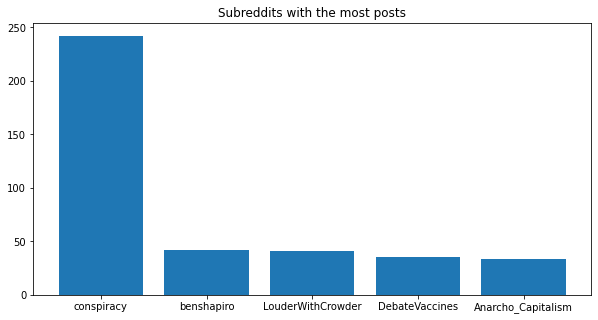

 % of Troll posts in post history 0.23


In [13]:
get_account_details(redditor_name)
# get_account_details("")